In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools
from matplotlib.lines import Line2D
from scipy import linalg
import qinfer
import scipy

sys.path.append("/home/bf16951/QMD")
import qmla


In [2]:
def latex_old_style_nv(name):
    if name == 'x' or name == 'y' or name == 'z':
        return '$' + name + '$'

    num_qubits = qmla.construct_models.get_num_qubits(name)
    terms = name.split('PP')
    rotations = ['xTi', 'yTi', 'zTi']
    hartree_fock = ['xTx', 'yTy', 'zTz']
    transverse = ['xTy', 'xTz', 'yTz', 'yTx', 'zTx', 'zTy']

    present_r = []
    present_hf = []
    present_t = []

    for t in terms:
        if t in rotations:
            present_r.append(t[0])
        elif t in hartree_fock:
            present_hf.append(t[0])
        elif t in transverse:
            string = t[0] + t[-1]
            present_t.append(string)
        # else:
        #     print("Term",t,"doesn't belong to rotations, Hartree-Fock or transverse.")
        #     print("Given name:", name)
    present_r.sort()
    present_hf.sort()
    present_t.sort()

    r_terms = ','.join(present_r)
    hf_terms = ','.join(present_hf)
    t_terms = ','.join(present_t)

    latex_term = ''
    if len(present_r) > 0:
        latex_term += r'\hat{S}_{' + r_terms + '}'
    if len(present_hf) > 0:
        latex_term += r'\hat{A}_{' + hf_terms + '}'
    if len(present_t) > 0:
        latex_term += r'\hat{T}_{' + t_terms + '}'

    final_term = '$' + latex_term + '$'
    if final_term != '$$':
        return final_term

    else:
        plus_string = ''
        for i in range(num_qubits):
            plus_string += 'P'
        individual_terms = name.split(plus_string)
        individual_terms = sorted(individual_terms)

        latex_term = '+'.join(individual_terms)
        final_term = '$' + latex_term + '$'
        return final_term

In [132]:
exp_results = os.path.abspath("/home/bf16951/bc_results/2019/Oct_02/18_01")
sim_results = os.path.abspath("/home/bf16951/bc_results/2019/Oct_03/17_43")


datapath = os.path.abspath("/home/bf16951/QMD/qmla/exploration_strategies/nv_centre_spin_characterisation/data/NVB_rescale_dataset.p")
exp_system_dynamics = pickle.load(open(datapath, 'rb'))
exp_times = sorted(list(exp_data))
exp_ev = [exp_data[t] for t in exp_times]
sim_times = np.arange(0, 1*max(exp_data), 0.05)
sim_system_dynamics = pickle.load(open(
    os.path.join(
        sim_results, 'true_expec_vals.p'
    ), 'rb'
))
exp_save_file = os.path.join(
    "..",
    "experimental_study", 
    "figures", "reproduced_dyamics_exp.pdf"
)
sim_save_file = os.path.join(
    "..",
    "experimental_study", 
    "figures", "reproduced_dyamics_sim.pdf"
)


exp_top_models = [
    'xTiPPyTiPPzTiPPzTz',
    'xTiPPxTxPPyTiPPzTiPPzTz',
    'xTiPPyTiPPyTyPPzTiPPzTz',
    'yTiPPzTiPPzTz', 
]
sim_top_models = [
    'xTiPPyTiPPzTiPPzTz',
    'xTiPPxTxPPyTiPPzTiPPzTz',
    'xTiPPyTiPPyTyPPzTiPPzTz',
    'xTiPPxTxPPyTiPPyTyPPzTiPPzTz',
]

In [123]:
from lfig import LatexFigure

In [124]:
def distill_expectation_values(
    respath,
    top_models,
    system_dynamics, 
):
    results_files = [f for f in os.listdir(respath) if f.startswith('res')]
    champ_params = pd.DataFrame()
    true_champ = []
    store_champ_instances = {}
    sim_times = sorted(system_dynamics.keys()) 

    exp_vals_by_model = {}
    for r in results_files:
        res_file = os.path.join(respath, r)
        res = pickle.load(open(res_file, 'rb'))

        true_champ.append(res['QID'])
        store_champ_instances[res['QID']] = res

        params = res['LearnedParameters']
        model = res['NameAlphabetical']

        if model in top_models:
            ham = None
            for p in params: 
                if ham is None: 
                    ham = params[p] * qmla.construct_models.compute(p)
                else:
                    ham += params[p] * qmla.construct_models.compute(p)

            params['qid'] = res['QID']
            params['ham'] = ham
            params['model'] = model
            p = pd.Series(params)

            champ_params = champ_params.append(
                p, ignore_index=True
            )
            exp_vals = [
                qmla.shared_functionality.expectation_value_functions.hahn_evolution(
                    ham = np.array(ham)    , 
                    t = t, 
                    state = np.array([0.5, 0.5, 0.5, 0.5])
                ) for t in sim_times
            ]
            if model not in exp_vals_by_model:
                exp_vals_by_model[model] = pd.DataFrame()
                exp_vals_by_model[model]['time'] = sim_times

            num_cols = len(exp_vals_by_model[model].keys())
            exp_vals_by_model[model][num_cols] = exp_vals    
    return exp_vals_by_model

In [137]:
def plot_dynamics(
    exp_vals_by_model, 
    system_dynamics, 
    top_models, 
    save_file
):
    lf = LatexFigure(
    #     auto_gridspec = len(top_models),
        auto_label=False, 
        gridspec_layout = (1, 4),
        gridspec_params = {'wspace' : 0.05}
    )

    champ_models = list(exp_vals_by_model)
    system_times = sorted(system_dynamics.keys())
    system_msmsts = [
        system_dynamics[t] for t in system_times
    ]
    for model in top_models:
        ax = lf.new_axis()
        this_model_exp_vals = exp_vals_by_model[model]

        slice_df = this_model_exp_vals.set_index('time')
        slice_df = slice_df.T

        median = slice_df.median().values
        mean = slice_df.mean().values
        std =slice_df.std().values

        upper = median + std
        lower = median - std
        
        mod_name = latex_old_style_nv(model)

        ax.plot(system_times, median, label=mod_name)
        ax.fill_between(
            system_times, 
            upper, lower, 
            alpha=0.4, 
        )
        ax.scatter(
            system_times, system_msmsts, c='red', s=5, 
        )
    #     ax.legend(loc='upper right')
        ax.set_title(mod_name)
        ax.set_ylim(-.05,1.05)

        if ax.col == 0:
            ax.set_yticks([0, 0.5, 1])
        else:
            ax.set_yticks([])
        if ax.row == lf.num_rows -1 :
            ax.set_xlim(0, 4.5)
            ax.set_xticks([0, 2, 4,])
        else:
            ax.set_xticks([])

    ylabel = r"$\Pr\left( 0|  \hat{H}_j, |+\rangle, t \right)$"
    lf.fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical')
    lf.fig.text(0.45, -0.2, "Time ($\mu s$)", )

    lf.save(save_file)


In [ ]:
sim_exp_vals = distill_expectation_values(
    sim_results, 
    system_dynamics=sim_system_dynamics, 
    top_models=sim_top_models
)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


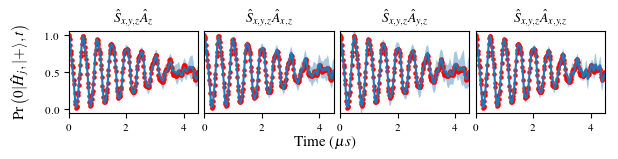

In [140]:
plot_dynamics(
    exp_vals_by_model = sim_exp_vals, 
    system_dynamics = sim_system_dynamics,
    top_models = sim_top_models, 
    save_file = sim_save_file
)

In [ ]:
experimental_exp_vals = distill_expectation_values(
    exp_results, 
    system_dynamics=exp_system_dynamics, 
    top_models=exp_top_models
)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


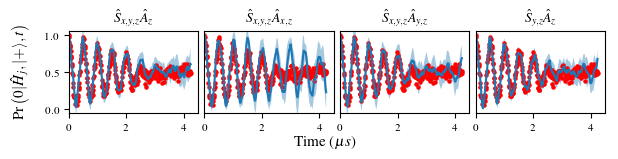

In [141]:
plot_dynamics(
    exp_vals_by_model = experimental_exp_vals, 
    system_dynamics = exp_system_dynamics,
    top_models = exp_top_models, 
    save_file = exp_save_file
)